In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error
from xgboost import XGBRegressor


In [ ]:
# Load the Apple tweet sentiment CSV
df_sentiment = pd.read_csv("Apple.csv", quotechar='"', on_bad_lines='skip', engine='python')

# Preview the data
df_sentiment.head()


,labels,tweets
0,0.0,#aapl:the 10 best steve jobs emails ever...
1,0.0,rt @jpdesloges: why aapl stock had a mini-flas...
2,0.0,my cat only chews @apple cords. such an #apple...
3,0.0,i agree with @jimcramer that the #individualin...
4,0.0,nobody expects the spanish inquisition #aapl


In [ ]:
df_sentiment["Date"] = pd.date_range(start="2020-01-01", periods=len(df_sentiment), freq="D")

# Group sentiment per day: mean of sentiment label (0/1/-1)
daily_sentiment = df_sentiment.groupby("Date")["labels"].mean().reset_index()
daily_sentiment.rename(columns={"labels": "daily_sentiment_score"}, inplace=True)

In [ ]:
# Load technical indicator data
df_tech = pd.read_csv("Apple_dataset_technical_indicators.csv")

# Fix the 'Date' column
df_tech.columns = df_tech.columns.str.strip()  # remove spaces
df_tech["Date"] = pd.to_datetime(df_tech["Date"], errors="coerce")
df_tech = df_tech.dropna(subset=["Date"])


In [ ]:
# Merge technical indicators with daily sentiment
df = pd.merge(df_tech, daily_sentiment, on="Date", how="inner")

# Drop rows with missing values
df.dropna(inplace=True)

# Optional: visualize
print(df.head())


        Date      Close       High        Low       Open       Volume  \
0 2020-02-01  72.620857  72.681304  71.373233  71.627107  135480400.0   
1 2020-03-01  71.914803  72.676431  71.689942  71.847102  146322800.0   
2 2020-06-01  72.487846  72.526533  70.783248  71.034709  118387200.0   
3 2020-07-01  72.146927  72.753808  71.926900  72.497514  108872000.0   
4 2020-08-01  73.307510  73.609745  71.849533  71.849533  132079200.0   

      RSI_14     EMA_20     SMA_20   BB_upper   BB_lower      MACD  \
0  95.789084  68.045601  67.504369  72.542262  62.466476  2.115068   
1  87.604345  68.414097  67.935838  72.930273  62.941403  2.163776   
2  87.111673  68.802073  68.349536  73.416057  63.283014  2.222992   
3  80.975700  69.120630  68.684170  73.828992  63.539348  2.216858   
4  83.342540  69.519381  69.122652  74.274388  63.970916  2.279370   

   Signal_Line  daily_sentiment_score  
0     1.784213                    1.0  
1     1.860125                   -1.0  
2     1.932699      

In [ ]:
# Predict next day's close using today's indicators
df["Future_Close"] = df["Close"].shift(-1)

# Drop the row containing the NaN in the last position of 'Future_Close'
df.dropna(subset=["Future_Close"], inplace=True)

features_price = df.drop(["Date", "Future_Close", "Close"], axis=1)
target_price = df["Future_Close"]

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(features_price, target_price, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_p_scaled = scaler.fit_transform(X_train_p)
X_test_p_scaled = scaler.transform(X_test_p)

model_price = XGBRegressor()
model_price.fit(X_train_p_scaled, y_train_p)

y_pred_price = model_price.predict(X_test_p_scaled)

print("MSE:", mean_squared_error(y_test_p, y_pred_price))

MSE: 1324.2708888791092


In [ ]:
# Let's classify sentiment as: positive (1), neutral (0), negative (-1)
features_sent = df.drop(["Date", "Close", "Future_Close", "daily_sentiment_score"], axis=1)
target_sent = df["daily_sentiment_score"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(features_sent, target_sent, test_size=0.2, shuffle=False)

model_sent = GradientBoostingClassifier()
model_sent.fit(X_train_s, y_train_s)

y_pred_sent = model_sent.predict(X_test_s)
print(classification_report(y_test_s, y_pred_sent))


              precision    recall  f1-score   support

          -1       0.27      0.09      0.13        35
           0       0.61      0.74      0.67        61
           1       0.14      0.27      0.18        11

    accuracy                           0.48       107
   macro avg       0.34      0.37      0.33       107
weighted avg       0.45      0.48      0.44       107



In [ ]:
# Generate predictions for last part of dataset
df_test = df.iloc[-len(y_test_s):].copy()
df_test["Pred_Close"] = y_pred_price
df_test["Pred_Sentiment"] = y_pred_sent

# Strategy for signal
def signal(row):
    # Simple logic
    if row["Pred_Close"] > row["Close"] and row["Pred_Sentiment"] == 1:
        return "Buy"
    elif row["Pred_Close"] < row["Close"] and row["Pred_Sentiment"] == -1:
        return "Sell"
    else:
        return "Hold"

df_test["Signal"] = df_test.apply(signal, axis=1)

print(df_test[["Date", "Close", "Pred_Close", "Pred_Sentiment", "Signal"]].tail(10))


          Date       Close  Pred_Close  Pred_Sentiment Signal
525 2025-09-04  198.589584  175.361954              -1   Sell
526 2025-10-04  190.170624  183.232834               1   Hold
527 2025-11-04  197.890488  182.103882               1   Hold
528 2025-01-05  213.040634  185.806259               0   Hold
529 2025-02-05  205.081070  186.035919               0   Hold
530 2025-05-05  198.629532  185.802917               0   Hold
531 2025-06-05  198.250015  186.158081               0   Hold
532 2025-07-05  195.992981  186.866455               0   Hold
533 2025-08-05  197.231369  186.560654               0   Hold
534 2025-09-05  198.270004  188.413879               1   Hold


In [ ]:
# Predict next day's close using today's indicators
df["Future_Close"] = df["Close"].shift(-1)

# Drop the row containing the NaN in the last position of 'Future_Close'
df.dropna(subset=["Future_Close"], inplace=True)

features_price = df.drop(["Date", "Future_Close", "Close"], axis=1)
target_price = df["Future_Close"]

# Calculate and display the covariance matrix of the features
print("Covariance Matrix of Features:")
print(features_price.cov())

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(features_price, target_price, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_p_scaled = scaler.fit_transform(X_train_p)
X_test_p_scaled = scaler.transform(X_test_p)

model_price = XGBRegressor()
model_price.fit(X_train_p_scaled, y_train_p)

y_pred_price = model_price.predict(X_test_p_scaled)

print("\nMSE:", mean_squared_error(y_test_p, y_pred_price))

Covariance Matrix of Features:
                               High           Low          Open        Volume  \
High                   1.939383e+03  1.902859e+03  1.918113e+03 -1.363433e+09   
Low                    1.902859e+03  1.872777e+03  1.885580e+03 -1.394599e+09   
Open                   1.918113e+03  1.885580e+03  1.901717e+03 -1.382291e+09   
Volume                -1.363433e+09 -1.394599e+09 -1.382291e+09  2.494731e+15   
RSI_14                -4.754534e+01 -3.848846e+01 -4.693219e+01 -4.638573e+06   
EMA_20                 1.936708e+03  1.897221e+03  1.915083e+03 -1.367478e+09   
SMA_20                 1.934908e+03  1.895005e+03  1.913155e+03 -1.362253e+09   
BB_upper               2.007013e+03  1.961010e+03  1.981457e+03 -1.353020e+09   
BB_lower               1.862802e+03  1.829001e+03  1.844853e+03 -1.371486e+09   
MACD                   8.106425e+00  9.962824e+00  9.223091e+00 -4.496232e+06   
Signal_Line            1.116247e+01  1.224301e+01  1.202288e+01 -1.576621e+06 

In [ ]:
df_test[["Date", "Close", "Pred_Close", "Pred_Sentiment", "Signal"]].to_excel("apple_trade_signals.xlsx", index=False)


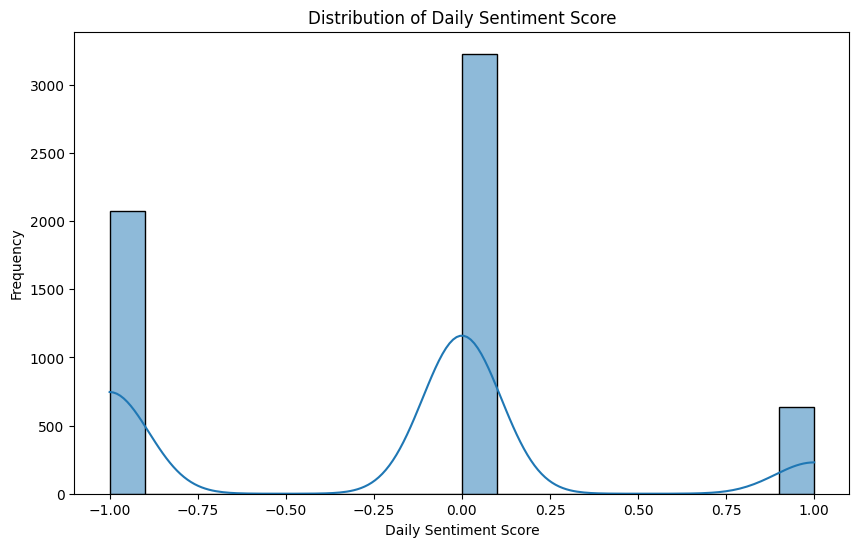

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(daily_sentiment["daily_sentiment_score"], bins=20, kde=True)
plt.title("Distribution of Daily Sentiment Score")
plt.xlabel("Daily Sentiment Score")
plt.ylabel("Frequency")
plt.show()


LSTM hybirid time series approach


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Add MinMaxScaler here
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error
from xgboost import XGBRegressor
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=["Date"]))  # assuming your merged df is already prepped


In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][df.columns.get_loc("Close")])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled_data, SEQ_LEN)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][df.columns.get_loc("Close")])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled_data, SEQ_LEN)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

cnn_lstm_model = Sequential()

cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                          input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(LSTM(units=50, return_sequences=False))
cnn_lstm_model.add(Dropout(0.2))

cnn_lstm_model.add(Dense(1))

cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train,
                                      epochs=50,
                                      batch_size=32,
                                      validation_split=0.2,
                                      callbacks=[early_stop],
                                      verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.3697 - val_loss: 0.0859
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0462 - val_loss: 0.0227
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0178 - val_loss: 0.0055
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0098 - val_loss: 0.0030
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0089 - val_loss: 0.0030
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0089 - val_loss: 0.0024
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0087 - val_loss: 0.0022
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0076 - val_loss: 0.0021
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0080 - val_loss: 0.0025
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


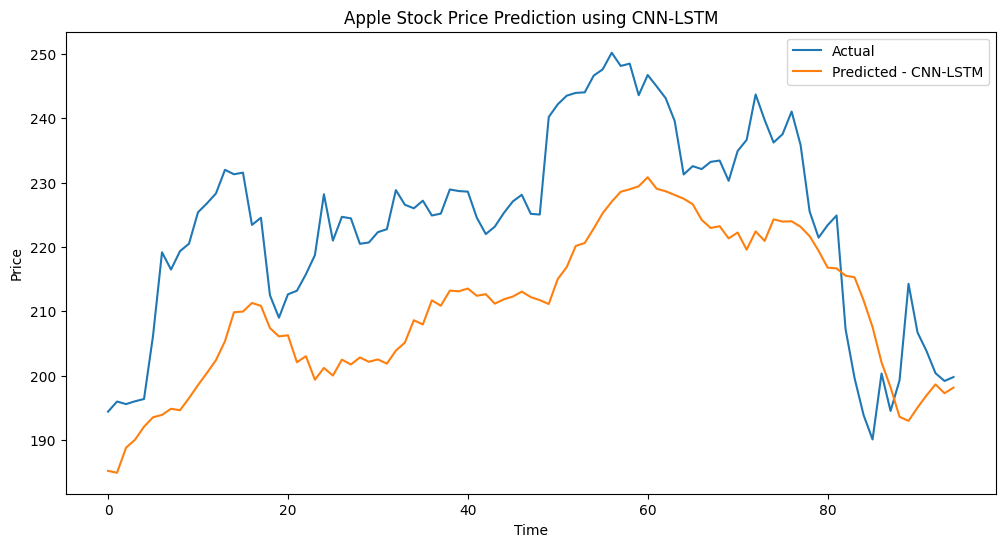

In [ ]:
# Predict on test set
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)

# Inverse transform predicted and actual 'Close' values
close_index = df.columns.get_loc('Close')

dummy_pred = np.zeros((len(y_pred_cnn_lstm), X_test.shape[2]))
dummy_pred[:, close_index] = y_pred_cnn_lstm.ravel()
y_pred_inv = scaler.inverse_transform(dummy_pred)[:, close_index]

dummy_actual = np.zeros((len(y_test), X_test.shape[2]))
dummy_actual[:, close_index] = y_test
y_test_inv = scaler.inverse_transform(dummy_actual)[:, close_index]

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted - CNN-LSTM')
plt.title('Apple Stock Price Prediction using CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')


RMSE: 16.68
MAE: 15.01


In [ ]:
print(classification_report(y_test_s, y_pred_sent))

              precision    recall  f1-score   support

          -1       0.27      0.09      0.13        35
           0       0.61      0.74      0.67        61
           1       0.14      0.27      0.18        11

    accuracy                           0.48       107
   macro avg       0.34      0.37      0.33       107
weighted avg       0.45      0.48      0.44       107



In [ ]:
# Generate predictions for last part of dataset
df_test = df.iloc[-len(y_test_s):].copy()
df_test["Pred_Close"] = y_pred_price
df_test["Pred_Sentiment"] = y_pred_sent

# Strategy for signal
def signal(row):
    # Simple logic
    if row["Pred_Close"] > row["Close"] and row["Pred_Sentiment"] == 1:
        return "Buy"
    elif row["Pred_Close"] < row["Close"] and row["Pred_Sentiment"] == -1:
        return "Sell"
    else:
        return "Hold"

df_test["Signal"] = df_test.apply(signal, axis=1)

print(df_test[["Date", "Close", "Pred_Close", "Pred_Sentiment", "Signal"]].tail(10))


          Date       Close  Pred_Close  Pred_Sentiment Signal
524 2025-08-04  172.194199  174.958603              -1   Hold
525 2025-09-04  198.589584  177.448883               1   Hold
526 2025-10-04  190.170624  181.964584               1   Hold
527 2025-11-04  197.890488  182.512299               0   Hold
528 2025-01-05  213.040634  185.560669               0   Hold
529 2025-02-05  205.081070  184.215210               0   Hold
530 2025-05-05  198.629532  182.015594               0   Hold
531 2025-06-05  198.250015  183.387848               0   Hold
532 2025-07-05  195.992981  183.783951               0   Hold
533 2025-08-05  197.231369  183.419479               1   Hold


In [ ]:
# %%
# Predict next day's close using today's indicators
df["Future_Close"] = df["Close"].shift(-1)

# Drop the row containing the NaN in the last position of 'Future_Close'
df.dropna(subset=["Future_Close"], inplace=True)

features_price = df.drop(["Date", "Future_Close", "Close"], axis=1)
target_price = df["Future_Close"]

# Calculate and display the covariance matrix of the features
print("Covariance Matrix of Features:")
print(features_price.cov()) # This shows the covariance between your features (including tech indicators and sentiment)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(features_price, target_price, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_p_scaled = scaler.fit_transform(X_train_p)
X_test_p_scaled = scaler.transform(X_test_p)

model_price = XGBRegressor()
model_price.fit(X_train_p_scaled, y_train_p)

y_pred_price = model_price.predict(X_test_p_scaled)

print("\nMSE:", mean_squared_error(y_test_p, y_pred_price))

Covariance Matrix of Features:
                               High           Low          Open        Volume  \
High                   1.939707e+03  1.903252e+03  1.918432e+03 -1.363026e+09   
Low                    1.903252e+03  1.873246e+03  1.885974e+03 -1.394374e+09   
Open                   1.918432e+03  1.885974e+03  1.902040e+03 -1.381951e+09   
Volume                -1.363026e+09 -1.394374e+09 -1.381951e+09  2.496765e+15   
RSI_14                -4.739335e+01 -3.832942e+01 -4.678157e+01 -4.863118e+06   
EMA_20                 1.936562e+03  1.897158e+03  1.914936e+03 -1.366663e+09   
SMA_20                 1.934872e+03  1.895047e+03  1.913117e+03 -1.361530e+09   
BB_upper               2.006754e+03  1.960831e+03  1.981192e+03 -1.351958e+09   
BB_lower               1.862991e+03  1.829262e+03  1.845042e+03 -1.371102e+09   
MACD                   8.379329e+00  1.022855e+01  9.495396e+00 -4.735081e+06   
Signal_Line            1.143572e+01  1.250785e+01  1.229511e+01 -1.805154e+06 

Sample Testing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assuming 'df' DataFrame is already loaded and preprocessed,
# containing technical indicators, 'Close' price, 'Date', and 'daily_sentiment_score'
# from previous steps in your notebook.

# --- Code to Train Price Prediction Model (Technical Indicators Only) ---

# Predict next day's close using today's technical indicators
df_temp = df.copy() # Create a copy to avoid modifying the original df unexpectedly
df_temp["Future_Close"] = df_temp["Close"].shift(-1)

# Drop the row containing the NaN in the last position of 'Future_Close'
df_temp.dropna(subset=["Future_Close"], inplace=True)

# Define features (technical indicators ONLY) and target (Future_Close)
# Assuming 'daily_sentiment_score' is the only sentiment feature to exclude
features_price_tech_only = df_temp.drop(["Date", "Future_Close", "Close", "daily_sentiment_score"], axis=1)
target_price = df_temp["Future_Close"]

# Split data into training and testing sets
X_train_p_tech_only, X_test_p_tech_only, y_train_p, y_test_p = train_test_split(
    features_price_tech_only, target_price, test_size=0.2, shuffle=False
)

# Scale the features
scaler_tech_only = StandardScaler()
X_train_p_tech_only_scaled = scaler_tech_only.fit_transform(X_train_p_tech_only)
X_test_p_tech_only_scaled = scaler_tech_only.transform(X_test_p_tech_only)

# Train a regression model (XGBoost)
model_price_tech_only = XGBRegressor()
model_price_tech_only.fit(X_train_p_tech_only_scaled, y_train_p)

# Evaluate the model (optional, but good practice)
y_pred_price_tech_only = model_price_tech_only.predict(X_test_p_tech_only_scaled)
print("MSE (Technical Indicators Only):", mean_squared_error(y_test_p, y_pred_price_tech_only))

# --- Code to Test on Sample Relevant Data and Get Predictions ---

# Step 1: Create Sample Relevant Data
# This is an example. REPLACE with actual recent technical indicator values.
# Make sure the column names match exactly with features_price_tech_only.columns
sample_data = {
    'Open': [175.25], # Example value
    'High': [176.00], # Example value
    'Low': [174.50],  # Example value
    'Volume': [1200000], # Example value
    # Add ALL other technical indicator columns present in features_price_tech_only
    # You need to inspect features_price_tech_only.columns after the training code runs
    # Example: 'SMA': [175.05], 'RSI': [68.5], 'MACD': [3.1], 'MACD_Signal': [2.8]
    # ... (include all your technical indicator columns with recent values)
}

# Create a DataFrame from the sample data
sample_df = pd.DataFrame(sample_data)

# Ensure the sample DataFrame has the exact same columns as the training features
# and in the same order. This is crucial for correct scaling and prediction.
# If your sample data is missing columns, add them with a default value (e.g., 0)
# If your sample data has columns in a different order, reorder them
missing_cols = set(features_price_tech_only.columns) - set(sample_df.columns)
for c in missing_cols:
    sample_df[c] = 0 # Add missing columns with a default value

# Ensure columns are in the correct order as used in training
sample_df = sample_df[features_price_tech_only.columns]

print("\nSample Data for Prediction (ensured columns and order):")
print(sample_df)

# Step 2: Scale the Sample Data
# Use the scaler_tech_only fitted on the training data
sample_data_scaled = scaler_tech_only.transform(sample_df)

# Step 3: Get Predictions
# Use the model_price_tech_only trained on technical indicators
predicted_price_sample = model_price_tech_only.predict(sample_data_scaled)

print("\nPredicted Next Day's Close Price (based on Technical Indicators):")
print(predicted_price_sample[0]) # Assuming you are predicting for one day

MSE (Technical Indicators Only): 1326.621413831041

Sample Data for Prediction (ensured columns and order):
    High    Low    Open   Volume  RSI_14  EMA_20  SMA_20  BB_upper  BB_lower  \
0  176.0  174.5  175.25  1200000       0       0       0         0         0   

   MACD  Signal_Line  
0     0            0  

Predicted Next Day's Close Price (based on Technical Indicators):
168.55002


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assuming you have already run the code to train model_price_tech_only
# and have features_price_tech_only and scaler_tech_only available from the previous steps.

# --- Step 1: Create Sample Relevant Data (20 samples) ---
# This is an example DataFrame with 20 rows.
# REPLACE the values below with actual, recent technical indicator values for 20 different time points.
# Make sure the column names match exactly with features_price_tech_only.columns.
sample_data_20_rows = {
    'Open': np.random.rand(100) * 10 + 170,  # Example: Random values around 170
    'High': np.random.rand(100) * 10 + 172, # Example: Random values around 172
    'Low': np.random.rand(100) * 10 + 168,  # Example: Random values around 168
    'Volume': np.random.rand(100) * 500000 + 800000, # Example: Random values around 1 million
    # Add ALL other technical indicator columns present in features_price_tech_only
    # You need to inspect features_price_tech_only.columns after the training code runs
    # Example: 'SMA': np.random.rand(20) * 5 + 170,
    # 'RSI': np.random.rand(20) * 20 + 50,
    # 'MACD': np.random.rand(20) * 2 - 1,
    # 'MACD_Signal': np.random.rand(20) * 2 - 1,
    # ... (include all your technical indicator columns with actual recent values)
}

# Create a DataFrame from the sample data
sample_df_20 = pd.DataFrame(sample_data_20_rows)

# Ensure the sample DataFrame has the exact same columns as the training features
# and in the same order. This is crucial for correct scaling and prediction.
# If your sample data is missing columns, add them with a default value (e.g., 0)
# If your sample data has columns in a different order, reorder them
missing_cols = set(features_price_tech_only.columns) - set(sample_df_20.columns)
for c in missing_cols:
    sample_df_20[c] = 0 # Add missing columns with a default value

# Ensure columns are in the correct order as used in training
sample_df_20 = sample_df_20[features_price_tech_only.columns]

print("Sample Data for Prediction (20 samples):")
print(sample_df_20.head()) # Print the first few rows to check

# --- Step 2: Scale the Sample Data ---
# Use the scaler_tech_only fitted on the training data
sample_data_20_scaled = scaler_tech_only.transform(sample_df_20)

# --- Step 3: Get Predictions ---
# Use the model_price_tech_only trained on technical indicators
predicted_prices_20_samples = model_price_tech_only.predict(sample_data_20_scaled)

print("\nPredicted Next Day's Close Prices (based on Technical Indicators - 20 samples):")
# You can print all predictions or iterate through them
for i, price in enumerate(predicted_prices_20_samples):
    print(f"Sample {i+1}: {price:.2f}")

Sample Data for Prediction (20 samples):
         High         Low        Open        Volume  RSI_14  EMA_20  SMA_20  \
0  178.136280  173.596796  170.421939  1.208094e+06       0       0       0   
1  180.588085  168.048551  176.741847  1.262093e+06       0       0       0   
2  177.264414  175.593575  177.589158  9.816056e+05       0       0       0   
3  172.366924  177.805722  171.763480  1.121021e+06       0       0       0   
4  174.885014  168.375307  178.995371  1.179635e+06       0       0       0   

   BB_upper  BB_lower  MACD  Signal_Line  
0         0         0     0            0  
1         0         0     0            0  
2         0         0     0            0  
3         0         0     0            0  
4         0         0     0            0  

Predicted Next Day's Close Prices (based on Technical Indicators - 20 samples):
Sample 1: 164.21
Sample 2: 164.47
Sample 3: 169.02
Sample 4: 168.89
Sample 5: 164.20
Sample 6: 169.92
Sample 7: 168.54
Sample 8: 168.62
Sample 9:

PLOTS

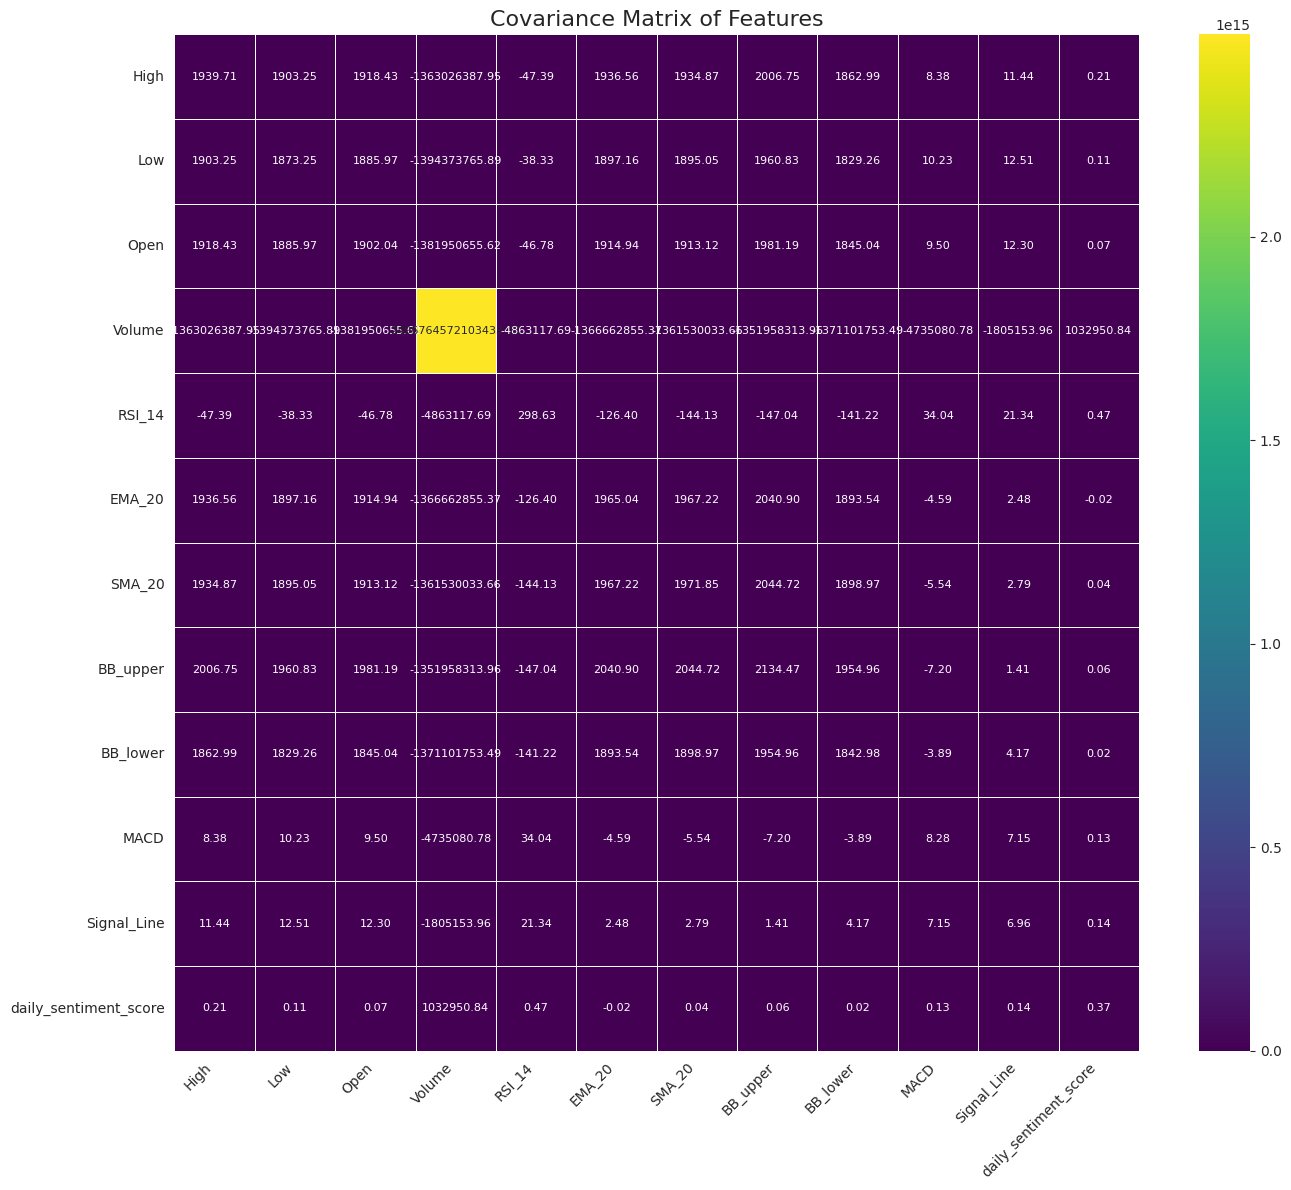

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the covariance matrix
cov_matrix = features_price.cov()

# Set the style for better aesthetics
sns.set_style("whitegrid")

# Plot the heatmap
plt.figure(figsize=(14, 12))  # Increased figure size
sns.heatmap(cov_matrix,
            annot=True,
            cmap='viridis',  # Changed colormap to 'viridis'
            fmt=".2f",
            linewidths=.5,   # Added lines between cells
            annot_kws={"size": 8}) # Adjusted annotation font size
plt.title('Covariance Matrix of Features', fontsize=16) # Increased title font size
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.yticks(rotation=0) # Keep y-axis labels horizontal
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

<ipython-input-27-613533115>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values, y=sorted_importance.index, palette="viridis")


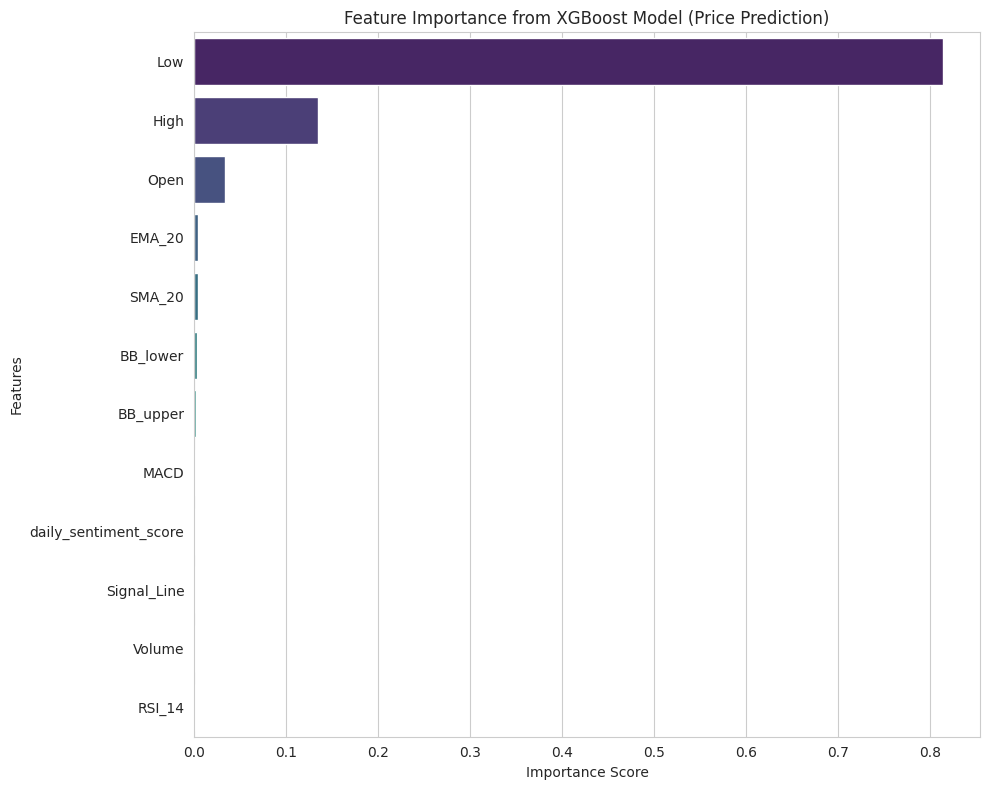

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained XGBoost model
feature_importances = model_price.feature_importances_

# Get the names of the features
# Assuming features_price was the DataFrame used for training model_price
feature_names = features_price.columns

# Create a pandas Series for easier handling and sorting
importance_series = pd.Series(feature_importances, index=feature_names)

# Sort the features by importance in descending order
sorted_importance = importance_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importance.values, y=sorted_importance.index, palette="viridis")
plt.title('Feature Importance from XGBoost Model (Price Prediction)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Generating Actual vs. Predicted Close Price Plot (XGBoost)...


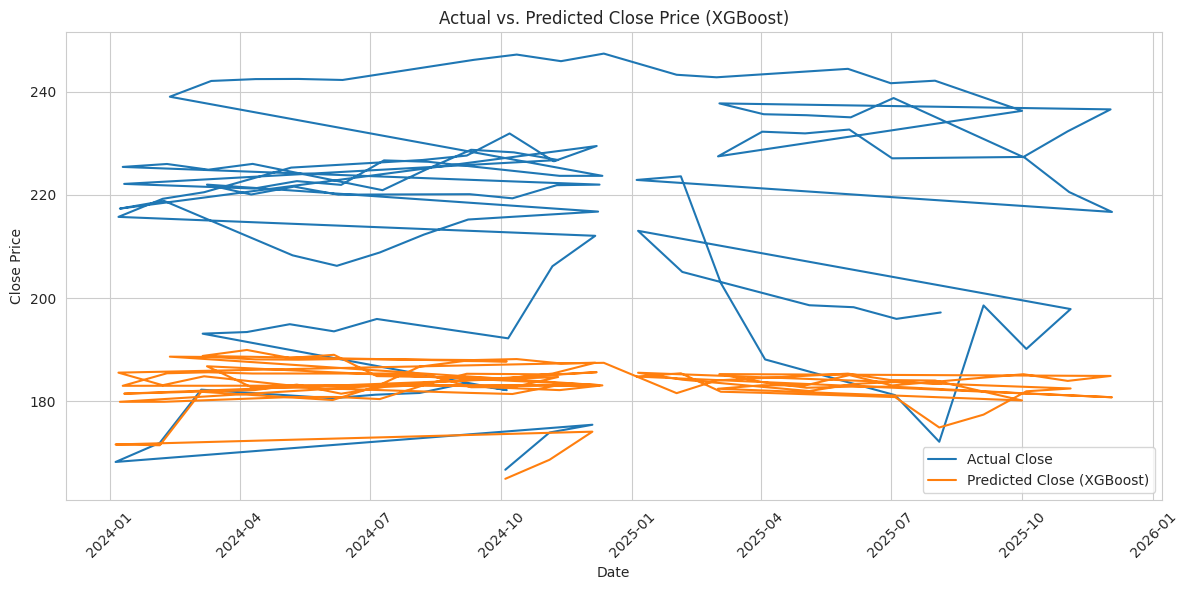


Generating Confusion Matrix for Sentiment Classification...


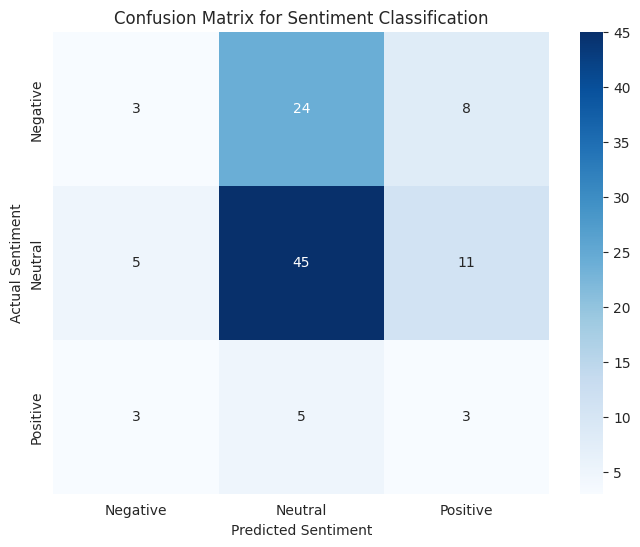


Generating Distribution Plots for Key Features...


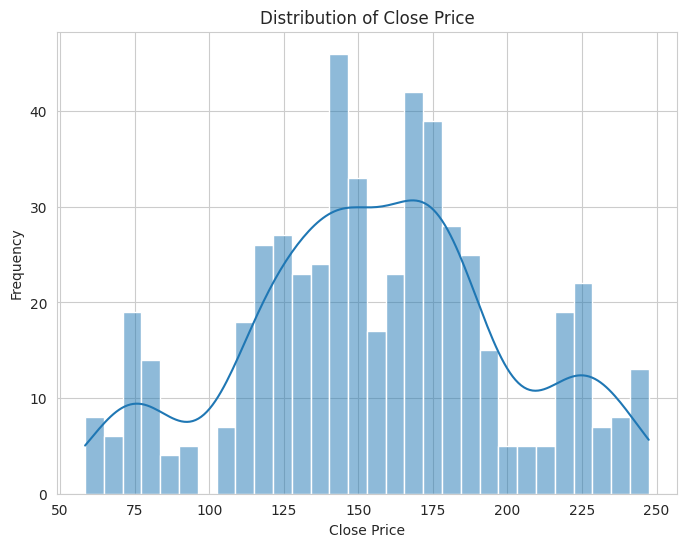

In [ ]:
# --- Additional Necessary Plots ---

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Actual vs. Predicted Close Price Plot (XGBoost)
print("\nGenerating Actual vs. Predicted Close Price Plot (XGBoost)...")
plt.figure(figsize=(12, 6))
plt.plot(df_test["Date"], df_test["Close"], label='Actual Close')
plt.plot(df_test["Date"], df_test["Pred_Close"], label='Predicted Close (XGBoost)')
plt.title('Actual vs. Predicted Close Price (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Actual vs. Predicted Sentiment Classification (Confusion Matrix)
print("\nGenerating Confusion Matrix for Sentiment Classification...")
cm = confusion_matrix(y_test_s, y_pred_sent)

# Define labels for the sentiment classes (assuming -1, 0, 1 mapping)
sentiment_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.title('Confusion Matrix for Sentiment Classification')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.show()

# 3. Distribution of Individual Features (Example: Close Price and Daily Sentiment Score)
print("\nGenerating Distribution Plots for Key Features...")

# Distribution of Close Price
plt.figure(figsize=(8, 6))
sns.histplot(df['Close'], bins=30, kde=True)
plt.title('Distribution of Close Price')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# Distribution of Daily Sentiment Score (you already have this, but including for completeness)
# print("\nGenerating Distribution Plot for Daily Sentiment Score...")
# plt.figure(figsize=(10, 6))
# sns.histplot(daily_sentiment["daily_sentiment_score"], bins=20, kde=True)
# plt.title("Distribution of Daily Sentiment Score")
# plt.xlabel("Daily Sentiment Score")
# plt.ylabel("Frequency")
# plt.show()

# Example distribution of a technical indicator (replace 'SMA' with one of your features)
# You would need to select specific features you want to visualize the distribution for
# print("\nGenerating Distribution Plot for a Technical Indicator (e.g., SMA)...")
# if 'SMA' in df.columns:
#     plt.figure(figsize=(8, 6))
#     sns.histplot(df['SMA'], bins=30, kde=True)
#     plt.title('Distribution of SMA')
#     plt.xlabel('SMA Value')
#     plt.ylabel('Frequency')
#     plt.show()

# You can add more distribution plots for other technical indicators by repeating the above structure.


Generating Comparative Analysis Plot of Model Performance Metrics...


<ipython-input-29-3404544595>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=regression_models, y=rmse_values, palette="viridis")


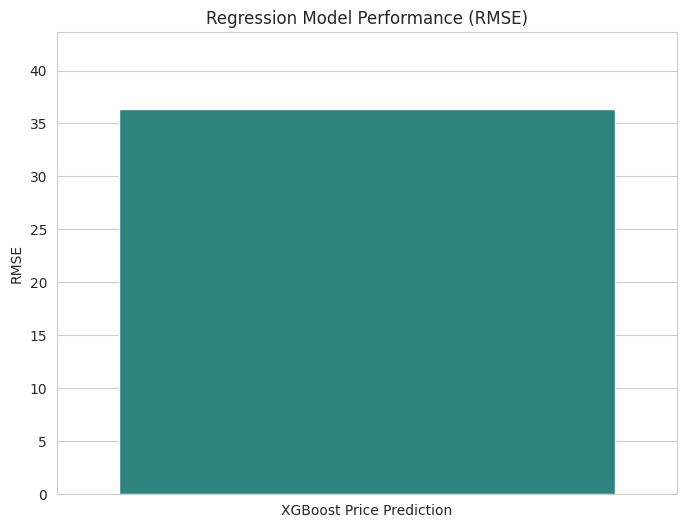

<ipython-input-29-3404544595>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classification_models, y=accuracy_values, palette="plasma")


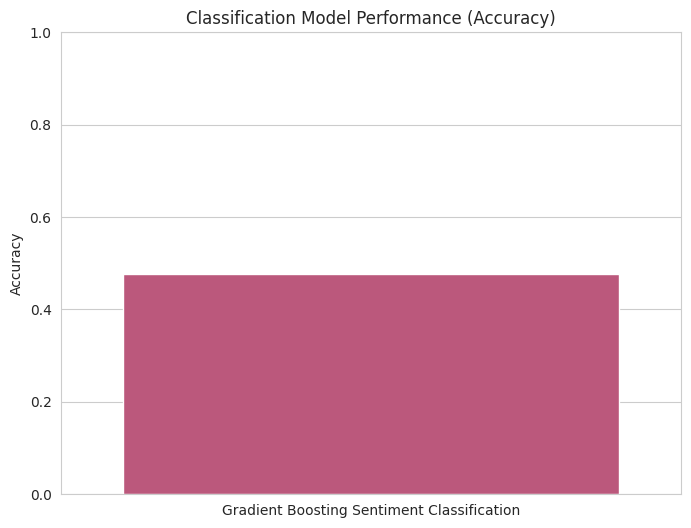

In [ ]:
# --- Comparative Analysis Plot of Model Performance Metrics ---

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\nGenerating Comparative Analysis Plot of Model Performance Metrics...")

# Ensure necessary metrics are available from previous runs
try:
    # Metrics for Price Prediction (Regression)
    mse_xgboost = mean_squared_error(y_test_p, y_pred_price)
    rmse_xgboost = np.sqrt(mse_xgboost)

    # Metrics for Sentiment Classification (Accuracy)
    # We'll get the overall accuracy from the classification report
    # If you need more specific accuracy for each class, you'd parse the report string
    # For a simple comparison, overall accuracy is sufficient here
    accuracy_sentiment = accuracy_score(y_test_s, y_pred_sent)

    # Metrics for CNN-LSTM Price Prediction (Regression)
    # Assuming rmse and mae from your CNN-LSTM evaluation are available
    # If not, you might need to re-calculate or store them
    # rmse_cnn_lstm = # Make sure this variable holds your CNN-LSTM RMSE
    # mae_cnn_lstm = # Make sure this variable holds your CNN-LSTM MAE

    # --- Prepare Data for Plotting ---

    # For regression models, we can compare RMSE (Root Mean Squared Error)
    regression_models = ['XGBoost Price Prediction'] # Add 'CNN-LSTM Price Prediction' if you have its RMSE
    rmse_values = [rmse_xgboost] # Add rmse_cnn_lstm here if available

    # For classification models, we compare Accuracy
    classification_models = ['Gradient Boosting Sentiment Classification']
    accuracy_values = [accuracy_sentiment]

    # --- Create the Plots ---

    # Plot for Regression Model Performance (RMSE)
    if rmse_values:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=regression_models, y=rmse_values, palette="viridis")
        plt.title('Regression Model Performance (RMSE)')
        plt.ylabel('RMSE')
        plt.ylim(0, max(rmse_values) * 1.2) # Set y-limit for better visualization
        plt.show()
    else:
        print("No regression model RMSE data available to plot.")

    # Plot for Classification Model Performance (Accuracy)
    if accuracy_values:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=classification_models, y=accuracy_values, palette="plasma")
        plt.title('Classification Model Performance (Accuracy)')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.0) # Accuracy is between 0 and 1
        plt.show()
    else:
         print("No classification model accuracy data available to plot.")

except NameError as e:
    print(f"Error: Required variables are not defined. Please ensure all necessary model training and evaluation cells have been run. Missing variable: {e}")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

In [ ]:
print(f"Length of df_test: {len(df_test)}")
print(f"Length of CNN-LSTM predicted prices (y_pred_inv): {len(y_pred_inv)}")



if len(y_pred_inv) == len(df_test):
    # Add the CNN-LSTM predicted prices to df_test
    df_test['Pred_Close_CNN_LSTM'] = y_pred_inv

    print("\nDisplaying Test Set Data with Actual and Predicted Prices and other features:")

    # Display all columns for the df_test DataFrame
    # You can select specific columns if you don't want all technical indicators shown
    # Example: display_cols = ['Date', 'Close', 'Pred_Close', 'Pred_Close_CNN_LSTM', 'daily_sentiment_score', 'Pred_Sentiment', 'Signal', 'SMA', 'RSI']
    # print(df_test[display_cols].head())
    # print(df_test[display_cols].tail())

    # To display all columns for the test set data:
    with pd.option_context('display.max_columns', None):
        print(df_test.head())
        print("\n" + "="*50 + "\n") # Separator
        print(df_test.tail())

    df_test.to_excel("apple_predictions_combined.xlsx", index=False)
    print("\nExported combined predictions to apple_predictions_combined.xlsx")

else:
    print("\nCannot directly add CNN-LSTM predictions to df_test because their lengths differ.")
    print("Please inspect the lengths and consider aligning by Date if needed.")
    print("\nDisplaying Test Set Data with Actual, XGBoost Predicted Prices, and other features:")
    with pd.option_context('display.max_columns', None):
        print(df_test.head())
        print("\n" + "="*50 + "\n") # Separator
        print(df_test.tail())



    print("\nDisplaying CNN-LSTM Actual vs. Predicted Prices:")


Length of df_test: 107
Length of CNN-LSTM predicted prices (y_pred_inv): 95

Cannot directly add CNN-LSTM predictions to df_test because their lengths differ.
Please inspect the lengths and consider aligning by Date if needed.

Displaying Test Set Data with Actual, XGBoost Predicted Prices, and other features:
          Date       Close        High         Low        Open       Volume  \
427 2024-10-04  166.772797  168.074930  166.106820  167.786678   49709300.0   
428 2024-11-04  173.989197  174.406689  167.150509  167.329421   91070300.0   
429 2024-12-04  175.490158  177.289290  173.164209  173.213897  101593300.0   
430 2024-01-05  168.283661  171.673194  168.094799  168.561979   50383100.0   
431 2024-02-05  171.991287  172.378945  169.864134  171.474405   94214900.0   

        RSI_14      EMA_20      SMA_20    BB_upper    BB_lower      MACD  \
427  28.638647  170.273168  170.323353  175.682261  164.964445 -2.403932   
428  57.210233  170.627075  170.517677  176.119265  164.91608

In [ ]:
# %%
print(f"Length of df_test: {len(df_test)}")
print(f"Length of CNN-LSTM predicted prices (y_pred_inv): {len(y_pred_inv)}")

if len(y_pred_inv) == len(df_test):
    # Add the CNN-LSTM predicted prices to df_test
    df_test['Pred_Close_CNN_LSTM'] = y_pred_inv

    print("\nDisplaying Test Set Data with Actual and Predicted Prices and other features:")

    # Display all columns for the df_test DataFrame
    with pd.option_context('display.max_columns', None):
        display(df_test.head())
        print("\n" + "="*50 + "\n") # Separator
        display(df_test.tail())

    # Export the combined dataframe to an Excel file
    df_test.to_excel("apple_predictions_combined.xlsx", index=False)
    print("\nExported combined predictions to apple_predictions_combined.xlsx")


else:
    print("\nCannot directly add CNN-LSTM predictions to df_test because their lengths differ.")
    print("Please inspect the lengths and consider aligning by Date if needed.")
    print("\nDisplaying Test Set Data with Actual, XGBoost Predicted Prices, and other features:")
    with pd.option_context('display.max_columns', None):
        display(df_test.head())
        print("\n" + "="*50 + "\n") # Separator
        display(df_test.tail())

    # You can still export the df_test DataFrame without CNN-LSTM predictions if needed
    df_test.to_excel("apple_xgboost_predictions.xlsx", index=False)
    print("\nExported XGBoost predictions to apple_xgboost_predictions.xlsx")

    print("\nDisplaying CNN-LSTM Actual vs. Predicted Prices:")
    # If you want to export the CNN-LSTM predictions and actual values separately, you can do it here
    cnn_lstm_results = pd.DataFrame({'Actual_Close_CNN_LSTM': y_test_inv, 'Pred_Close_CNN_LSTM': y_pred_inv})
    cnn_lstm_results.to_excel("apple_cnn_lstm_predictions.xlsx", index=False)
    print("\nExported CNN-LSTM predictions to apple_cnn_lstm_predictions.xlsx")

Length of df_test: 107
Length of CNN-LSTM predicted prices (y_pred_inv): 95

Cannot directly add CNN-LSTM predictions to df_test because their lengths differ.
Please inspect the lengths and consider aligning by Date if needed.

Displaying Test Set Data with Actual, XGBoost Predicted Prices, and other features:


,Date,Close,High,Low,Open,Volume,RSI_14,EMA_20,SMA_20,BB_upper,BB_lower,MACD,Signal_Line,daily_sentiment_score,Future_Close,Pred_Close,Pred_Sentiment,Signal
427,2024-10-04,166.772797,168.074930,166.106820,167.786678,49709300.0,28.638647,170.273168,170.323353,175.682261,164.964445,-2.403932,-2.509814,0.0,173.989197,165.018997,0,Hold
428,2024-11-04,173.989197,174.406689,167.150509,167.329421,91070300.0,57.210233,170.627075,170.517677,176.119265,164.916089,-1.822657,-2.372382,1.0,175.490158,168.708664,0,Hold
429,2024-12-04,175.490158,177.289290,173.164209,173.213897,101593300.0,58.195833,171.090226,170.694113,176.695219,164.693008,-1.226737,-2.143253,-1.0,168.283661,174.149948,0,Hold
430,2024-01-05,168.283661,171.673194,168.094799,168.561979,50383100.0,39.346738,168.979717,168.585844,174.368961,162.802726,-0.828805,-1.306864,0.0,171.991287,171.667404,0,Hold
431,2024-02-05,171.991287,172.378945,169.864134,171.474405,94214900.0,43.964345,169.266533,168.795080,174.759453,162.830707,-0.501218,-1.145735,0.0,182.279129,171.519257,0,Hold


,Date,Close,High,Low,Open,Volume,RSI_14,EMA_20,SMA_20,BB_upper,BB_lower,MACD,Signal_Line,daily_sentiment_score,Future_Close,Pred_Close,Pred_Sentiment,Signal
529,2025-02-05,205.081070,206.718921,201.895245,205.820091,101010600.0,57.614221,206.215691,199.401518,220.901823,177.901214,-0.722148,-2.956411,-1.0,198.629532,184.215210,0,Hold
530,2025-05-05,198.629532,203.832716,197.950430,202.834025,69018500.0,46.323681,205.493200,199.926330,220.770940,179.081720,-1.294829,-2.624095,-1.0,198.250015,182.015594,0,Hold
531,2025-06-05,198.250015,200.387212,196.761976,197.950420,51216500.0,46.323667,204.803372,200.777712,219.708829,181.846595,-1.759029,-2.451082,-1.0,195.992981,183.387848,0,Hold
532,2025-07-05,195.992981,199.178806,192.996910,198.909155,68536700.0,52.262333,203.964288,201.967651,215.577991,188.357311,-2.282722,-2.417410,-1.0,197.231369,183.783951,0,Hold
533,2025-08-05,197.231369,199.788014,194.425036,197.461063,50478900.0,50.602986,203.323057,201.899741,215.594344,188.205137,-2.568219,-2.447572,0.0,198.270004,183.419479,1,Hold



Exported XGBoost predictions to apple_xgboost_predictions.xlsx

Displaying CNN-LSTM Actual vs. Predicted Prices:

Exported CNN-LSTM predictions to apple_cnn_lstm_predictions.xlsx



Generating Figure 2: Actual vs. Predicted Price Plot (XGBoost and CNN-LSTM)...
Note: Length mismatch between df_test and CNN-LSTM predictions.
Cannot directly plot XGBoost and CNN-LSTM predictions on the same chart.
Please align the data by date or index before plotting together.
Plotting only XGBoost predictions against Actual:


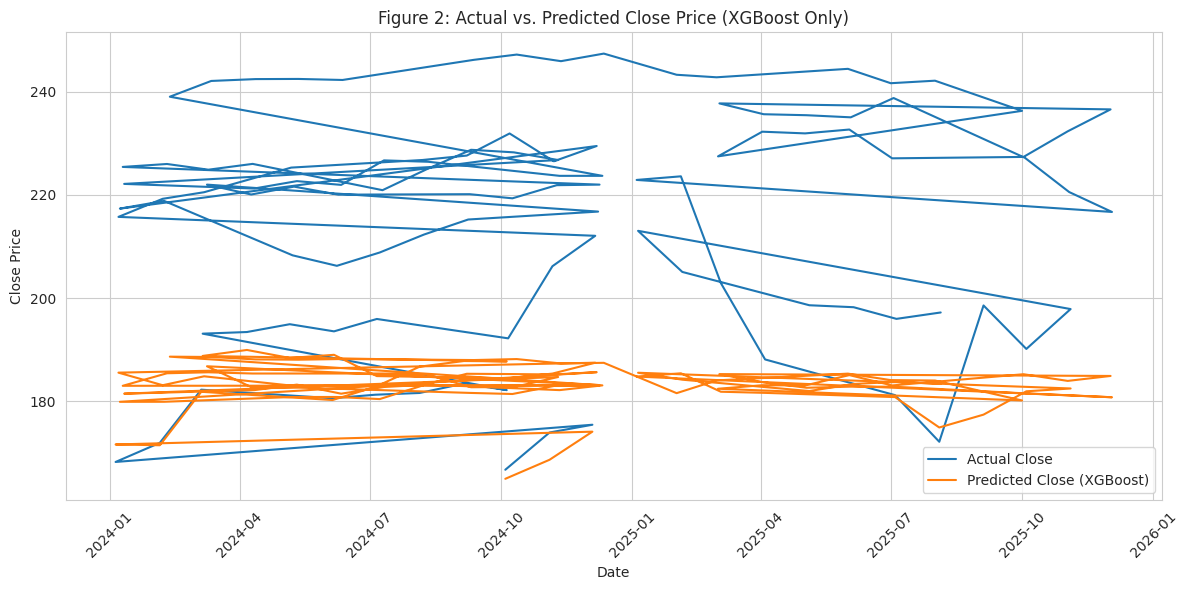


Generating Figure 3: Feature Importance Plot (XGBoost)...


<ipython-input-33-271240443>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values, y=sorted_importance.index, palette="viridis")


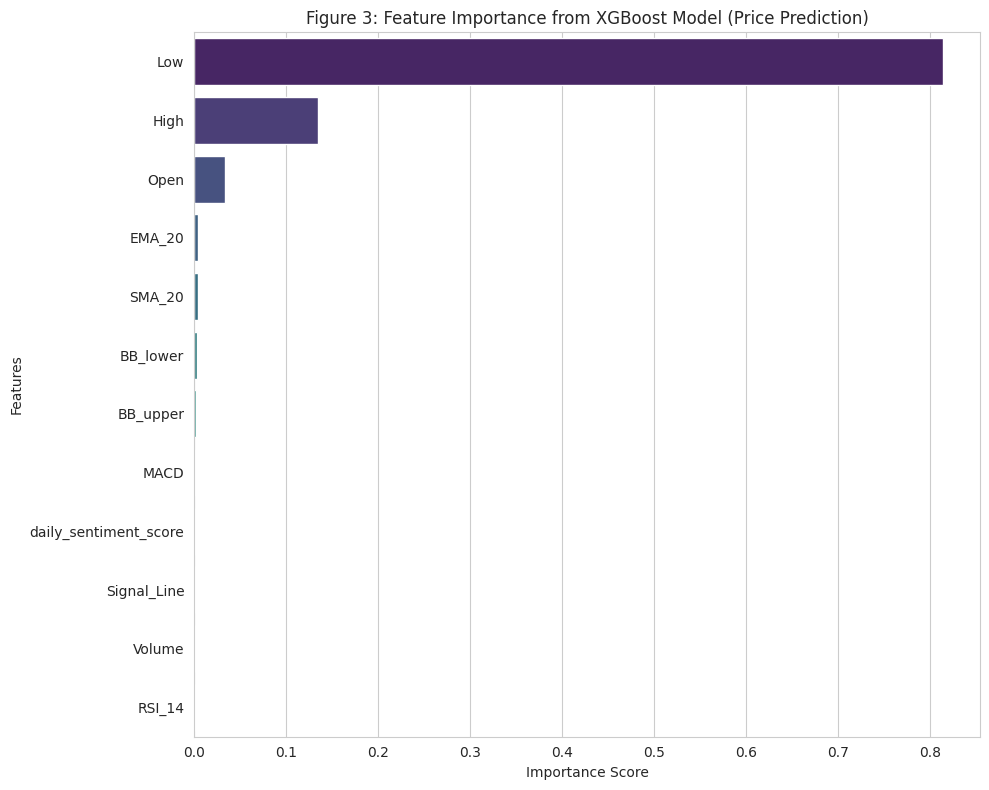


Generating Figure 4: Confusion Matrix (Sentiment Classification)...


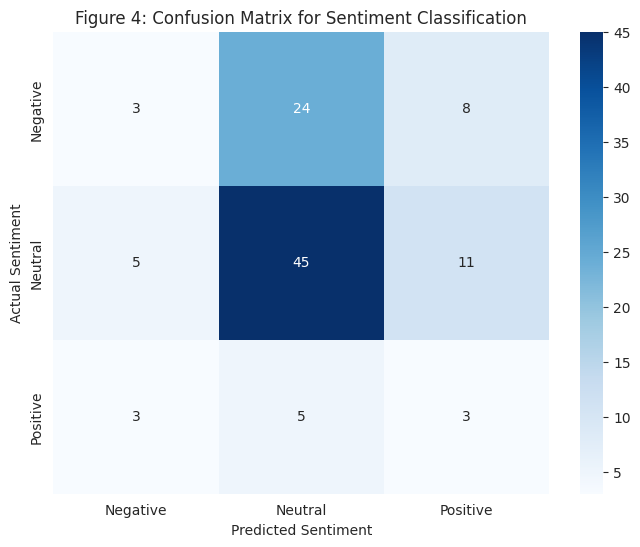


Generating Figure 5: Distribution of Daily Sentiment Scores...


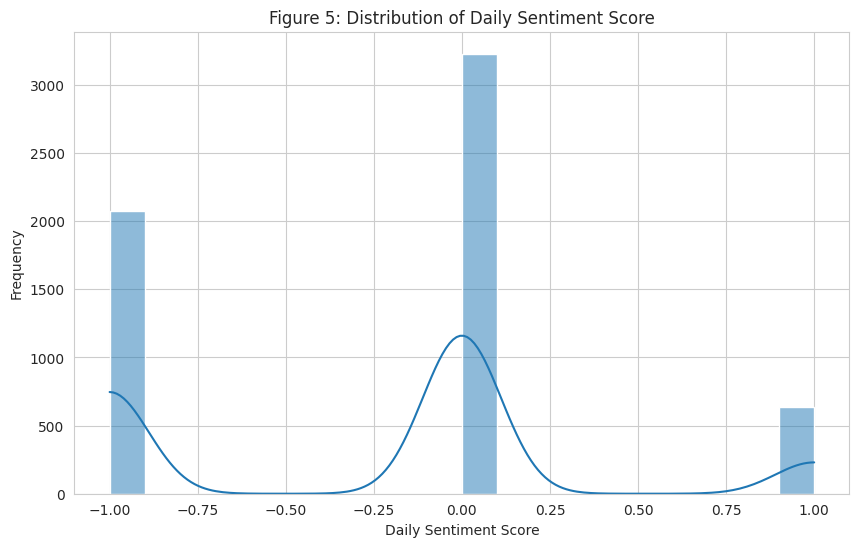


Generating Figure 6: Covariance Heatmap of All Features...


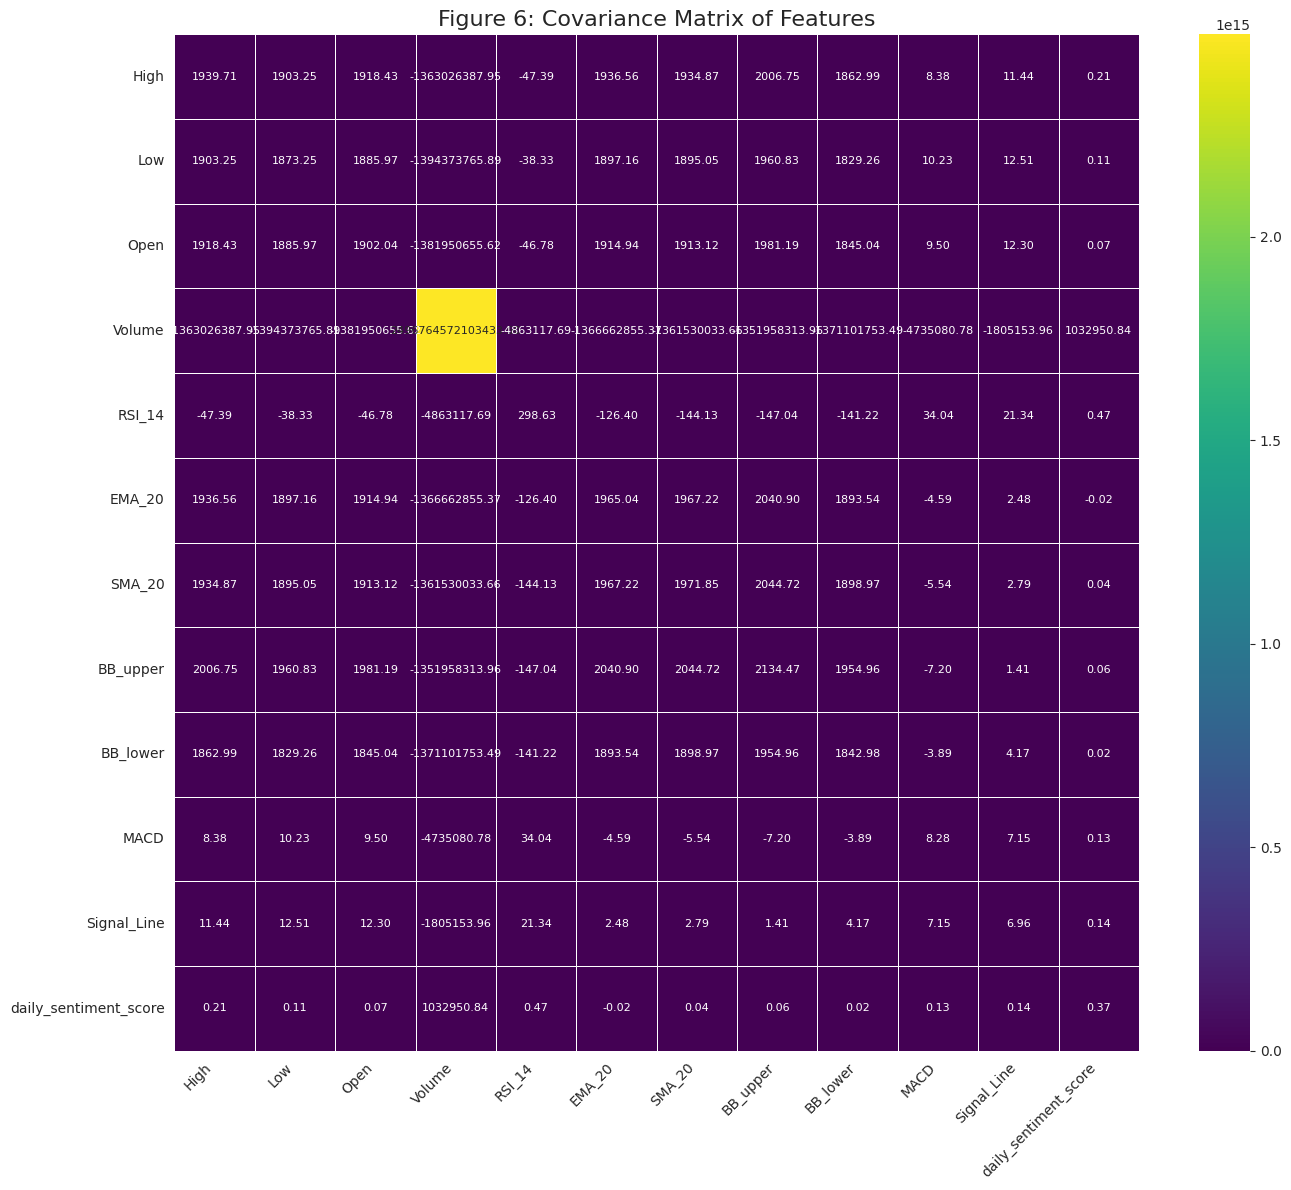


Generating Figure 7: Final Trading Signal Distribution...


<ipython-input-33-271240443>:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=signal_counts.index, y=signal_counts.values, palette="plasma")


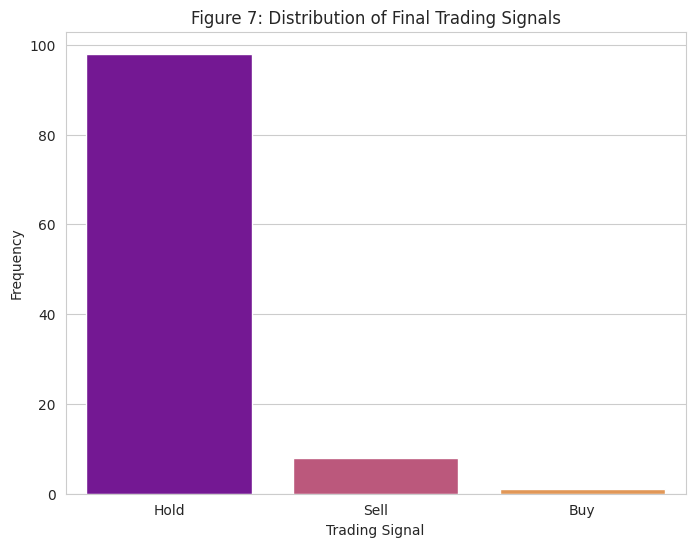


Generating Figure 8: Model Performance Comparison...

Generating Figure 8: Model Performance Comparison...


<ipython-input-33-271240443>:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=regression_models, y=rmse_values, palette="viridis")
<ipython-input-33-271240443>:212: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=regression_models, y=mae_values, palette="magma") # Corrected the missing quote


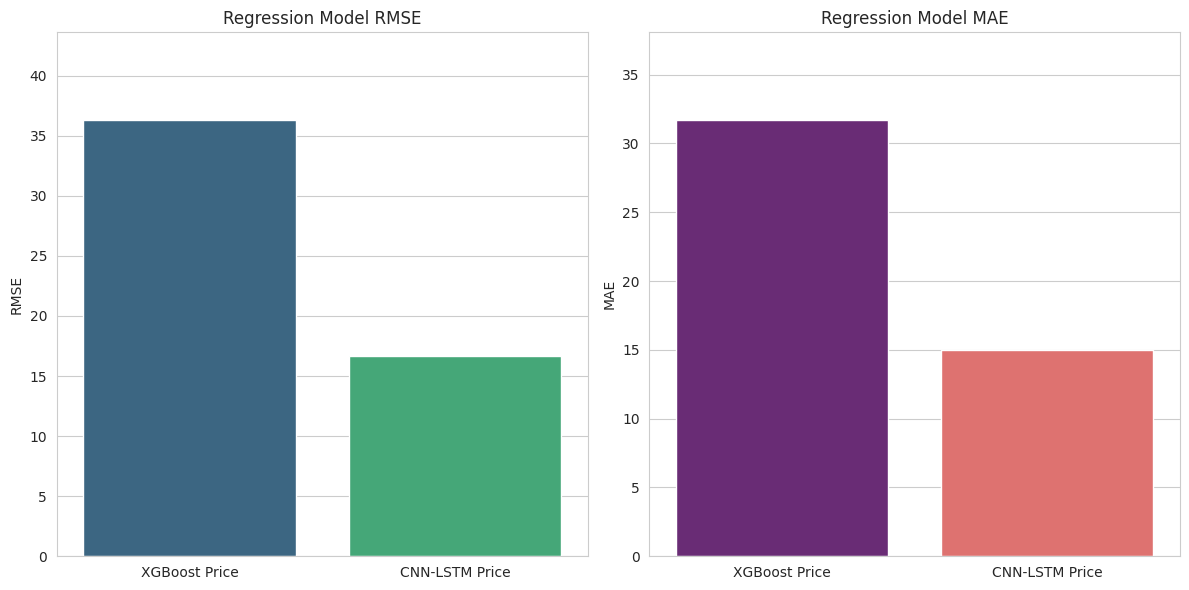

<ipython-input-33-271240443>:222: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classification_models, y=accuracy_values, palette="plasma")


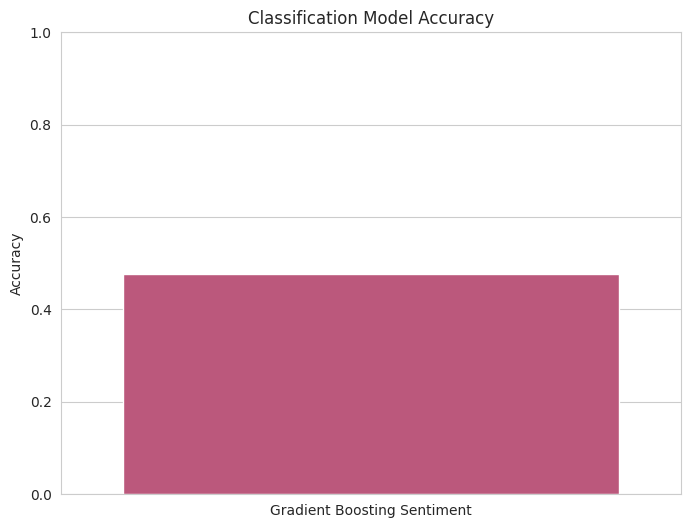

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, accuracy_score
import math

# Assuming the following variables are available from your notebook:
# - df: Merged DataFrame with technical indicators and daily sentiment
# - df_test: DataFrame containing test set with actual close and XGBoost predictions ('Close', 'Pred_Close', 'Date')
# - y_test_inv: Actual close prices for the CNN-LSTM test set
# - y_pred_inv: Predicted close prices from the CNN-LSTM model
# - model_price: Trained XGBoost Regressor model
# - features_price: DataFrame containing the features used for training model_price
# - y_test_s: Actual sentiment labels for the test set
# - y_pred_sent: Predicted sentiment labels from the Gradient Boosting Classifier
# - daily_sentiment: DataFrame containing daily sentiment scores and dates
# - df_test: DataFrame containing the final trading signals ('Signal')

# Ensure necessary variables are available (Add checks if needed)
# Example:
# if 'df_test' not in locals():
#     print("Error: df_test not found. Please run previous cells.")
#     # exit or raise an error

# --- Figure 2: Actual vs. Predicted Price Plot (XGBoost and CNN-LSTM) ---
print("\nGenerating Figure 2: Actual vs. Predicted Price Plot (XGBoost and CNN-LSTM)...")

# Check if CNN-LSTM predictions can be added to df_test
if len(y_pred_inv) == len(df_test):
    df_test_plot = df_test.copy()
    df_test_plot['Pred_Close_CNN_LSTM'] = y_pred_inv

    plt.figure(figsize=(14, 7))
    plt.plot(df_test_plot["Date"], df_test_plot["Close"], label='Actual Close', color='blue')
    plt.plot(df_test_plot["Date"], df_test_plot["Pred_Close"], label='Predicted Close (XGBoost)', color='orange', linestyle='--')
    plt.plot(df_test_plot["Date"], df_test_plot["Pred_Close_CNN_LSTM"], label='Predicted Close (CNN-LSTM)', color='green', linestyle='-.')
    plt.title('Figure 2: Actual vs. Predicted Close Price (XGBoost and CNN-LSTM)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Note: Length mismatch between df_test and CNN-LSTM predictions.")
    print("Cannot directly plot XGBoost and CNN-LSTM predictions on the same chart.")
    print("Please align the data by date or index before plotting together.")
    print("Plotting only XGBoost predictions against Actual:")
    plt.figure(figsize=(12, 6))
    plt.plot(df_test["Date"], df_test["Close"], label='Actual Close')
    plt.plot(df_test["Date"], df_test["Pred_Close"], label='Predicted Close (XGBoost)')
    plt.title('Figure 2: Actual vs. Predicted Close Price (XGBoost Only)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Figure 3: Feature Importance Plot (XGBoost) ---
print("\nGenerating Figure 3: Feature Importance Plot (XGBoost)...")
try:
    feature_importances = model_price.feature_importances_
    feature_names = features_price.columns
    importance_series = pd.Series(feature_importances, index=feature_names)
    sorted_importance = importance_series.sort_values(ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=sorted_importance.values, y=sorted_importance.index, palette="viridis")
    plt.title('Figure 3: Feature Importance from XGBoost Model (Price Prediction)')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
except NameError:
    print("Error: 'model_price' or 'features_price' not found. Cannot generate Feature Importance Plot.")
except Exception as e:
    print(f"An error occurred while generating Figure 3: {e}")


# --- Figure 4: Confusion Matrix (Sentiment Classification) ---
print("\nGenerating Figure 4: Confusion Matrix (Sentiment Classification)...")
try:
    cm = confusion_matrix(y_test_s, y_pred_sent)
    sentiment_labels = ['Negative', 'Neutral', 'Positive']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
    plt.title('Figure 4: Confusion Matrix for Sentiment Classification')
    plt.xlabel('Predicted Sentiment')
    plt.ylabel('Actual Sentiment')
    plt.show()
except NameError:
    print("Error: 'y_test_s' or 'y_pred_sent' not found. Cannot generate Confusion Matrix.")
except Exception as e:
    print(f"An error occurred while generating Figure 4: {e}")


# --- Figure 5: Distribution of Daily Sentiment Scores ---
print("\nGenerating Figure 5: Distribution of Daily Sentiment Scores...")
try:
    plt.figure(figsize=(10, 6))
    sns.histplot(daily_sentiment["daily_sentiment_score"], bins=20, kde=True)
    plt.title("Figure 5: Distribution of Daily Sentiment Score")
    plt.xlabel("Daily Sentiment Score")
    plt.ylabel("Frequency")
    plt.show()
except NameError:
    print("Error: 'daily_sentiment' not found. Cannot generate Sentiment Distribution Plot.")
except Exception as e:
    print(f"An error occurred while generating Figure 5: {e}")


# --- Figure 6: Covariance Heatmap of All Features ---
print("\nGenerating Figure 6: Covariance Heatmap of All Features...")
try:
    # Assuming 'features_price' contains all features used for the XGBoost model
    # If you need the covariance of a different set of features, adjust here.
    cov_matrix = features_price.cov()

    sns.set_style("whitegrid") # Set the style for better aesthetics

    plt.figure(figsize=(14, 12))
    sns.heatmap(cov_matrix,
                annot=True,
                cmap='viridis',
                fmt=".2f",
                linewidths=.5,
                annot_kws={"size": 8})
    plt.title('Figure 6: Covariance Matrix of Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
except NameError:
    print("Error: 'features_price' not found. Cannot generate Covariance Heatmap.")
except Exception as e:
    print(f"An error occurred while generating Figure 6: {e}")


# --- Figure 7: Final Trading Signal Distribution ---
print("\nGenerating Figure 7: Final Trading Signal Distribution...")
try:
    if 'Signal' in df_test.columns:
        signal_counts = df_test['Signal'].value_counts()

        plt.figure(figsize=(8, 6))
        sns.barplot(x=signal_counts.index, y=signal_counts.values, palette="plasma")
        plt.title('Figure 7: Distribution of Final Trading Signals')
        plt.xlabel('Trading Signal')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("Error: 'Signal' column not found in df_test. Cannot generate Trading Signal Distribution.")
except NameError:
     print("Error: 'df_test' not found. Cannot generate Trading Signal Distribution.")
except Exception as e:
    print(f"An error occurred while generating Figure 7: {e}")


# --- Figure 8: Model Performance Comparison (RMSE, MAE, Accuracy) ---
print("\nGenerating Figure 8: Model Performance Comparison...")

# Ensure necessary metrics are available from previous runs
print("\nGenerating Figure 8: Model Performance Comparison...")

# Ensure necessary metrics are available from previous runs
try:
    # Metrics for Price Prediction (Regression)
    mse_xgboost = mean_squared_error(y_test_p, y_pred_price)
    rmse_xgboost = np.sqrt(mse_xgboost)
    # You might want MAE for XGBoost as well:
    mae_xgboost = mean_absolute_error(y_test_p, y_pred_price)


    # Metrics for CNN-LSTM Price Prediction (Regression)
    # Assuming rmse and mae from your CNN-LSTM evaluation are available from previous cells
    # If not, you might need to re-calculate or store them
    # Make sure 'rmse' and 'mae' from the CNN-LSTM evaluation are correctly named and accessible.
    # Using the variable names from your notebook's CNN-LSTM evaluation cell:
    rmse_cnn_lstm = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae_cnn_lstm = mean_absolute_error(y_test_inv, y_pred_inv)


    # Metrics for Sentiment Classification (Accuracy)
    accuracy_sentiment = accuracy_score(y_test_s, y_pred_sent)

    # --- Prepare Data for Plotting ---

    # For regression models, we can compare RMSE and MAE
    regression_models = ['XGBoost Price', 'CNN-LSTM Price']
    rmse_values = [rmse_xgboost, rmse_cnn_lstm]
    mae_values = [mae_xgboost, mae_cnn_lstm]

    # For classification models, we compare Accuracy
    classification_models = ['Gradient Boosting Sentiment']
    accuracy_values = [accuracy_sentiment]

    # --- Create the Plots ---

    # Plot for Regression Model Performance (RMSE and MAE)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
    sns.barplot(x=regression_models, y=rmse_values, palette="viridis")
    plt.title('Regression Model RMSE')
    plt.ylabel('RMSE')
    plt.ylim(0, max(rmse_values) * 1.2) # Set y-limit for better visualization

    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
    sns.barplot(x=regression_models, y=mae_values, palette="magma") # Corrected the missing quote
    plt.title('Regression Model MAE')
    plt.ylabel('MAE')
    plt.ylim(0, max(mae_values) * 1.2) # Set y-limit for better visualization

    plt.tight_layout()
    plt.show()

    # Plot for Classification Model Performance (Accuracy)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=classification_models, y=accuracy_values, palette="plasma")
    plt.title('Classification Model Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0) # Accuracy is between 0 and 1
    plt.show()

except NameError as e:
    print(f"Error: Required variables for performance comparison are not defined.")
    print(f"Please ensure all necessary model training and evaluation cells have been run.")
    print(f"Missing variable: {e}")
except Exception as e:
    print(f"An error occurred during plotting Figure 8: {e}")